The problem that I am having with the very simple functions for the qmet and the enviroment is that these functions tend towards zero
and endup causing the teperature to oscilate with very sharp
changes, which seems unphysical

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from Segment import Body, Segment

In [2]:
# build our body 

tree = Segment(171380, 4.305, 59.539, "Torso")
tree.add_child(51.70, Segment(17556.0, 13.423, 17.3, "Head"))
tree.add_child(5.45, 
               Segment(9041.34, 0.814, 1.264, "LUArm").add_child(2.65,
               Segment(5739.14, 0.534, 0.271, "LFArm").add_child(1.20,
               Segment(1400.3, 0.369, 0.140, "LHand"))))
tree.add_child(5.45, 
               Segment(9041.34, 0.814, 1.264, "RUArm").add_child(2.65,
               Segment(5739.14, 0.534, 0.271, "RFArm").add_child(1.20,
               Segment(1400.3, 0.369, 0.140, "RHand"))))
tree.add_child(2.72, 
               Segment(29314.3, 1.640, 1.440, "LThigh").add_child(0.85,
               Segment(13973.7, 0.879, 0.380, "LLeg").add_child(0.56,
               Segment(2006.4, 0.456, 0.313, "LFoot"))))
tree.add_child(2.72, 
               Segment(29314.3, 1.640, 1.440, "RThigh").add_child(0.85,
               Segment(13973.7, 0.879, 0.380, "RLeg").add_child(0.56,
               Segment(2006.4, 0.456, 0.313, "RFoot"))))
body = Body(tree)

In [3]:
# Now build our functions for the warm parameter and cold parameter

def wrm(btree, bpram):
    """Defines the warm parameter, a weighted sum of temperature
    errors over the body
    """
    temps = btree.get_param("temp", True)
    tsets = btree.get_param("tset", True)
    skwts = btree.get_param("skwt", True)
    # induvidual wars are allways positive or zero, temp > tset
    err = np.clip(temps - tsets, 0, None)
    wmt = skwts * err
    return np.sum(wmt)

def cld(btree, bpram):
    """Defines the cold parameter, a weighted sum of temperature
    erros over the body
    """
    temps = btree.get_param("temp", True)
    tsets = btree.get_param("tset", True)
    skwts = btree.get_param("skwt", True)
    # induvidual wars are allways negative or zero, temp < tset
    err = np.clip(temps - tsets, None, 0)
    cldt = skwts * -err
    return np.sum(cldt)

# add the parameters to the body
tsets = [35.0, 36.1, 34.4, 34.9, 35.3, 34.4, 34.9, 35.3,
                     34.8, 34.3, 34.6, 34.8, 34.3, 34.6]
skwts = [0.493, 0.070, 0.023, 0.012, 0.092, 0.023, 0.012, 0.092,
                       0.050, 0.025, 0.017, 0.050, 0.025, 0.017]
chilf = [0.020, 0.850, 0.004, 0.026, 0.000, 0.004, 0.026, 0.000,
                       0.023, 0.012, 0.000, 0.023, 0.012, 0.000]

body.body_tree.set_param("tset", tsets)
body.body_tree.set_param("skwt", skwts)
body.body_tree.set_param("chilf", chilf)

# and register the warm and cld parameters
body.register_body_parameter("wrm", wrm, 0.0)
body.register_body_parameter("cld", cld, 0.0)

In [4]:
# And then build an update function to update the metabolic rate
qbase = body.body_tree.get_param("qmet")

def qmet_update(btree, bpvals):
    htemp = btree.childlinks[0][0].temp # head is childlink[0][0]
    htset = btree.childlinks[0][0].tset
    hcld = -np.clip(htemp-htset, None, 0)
    chs = 24.4 * bpvals["cld"] * btree.get_param("chilf", True)
    qmets = qbase + chs
    return list(qmets)

body.register_tree_update("qmet", qmet_update)

In [5]:
# now register the loging parameters

body.register_log_parameter("temp", "tree")
body.register_log_parameter("qmet", "tree")
body.register_log_parameter("env", "tree")
body.register_log_parameter("wrm", "body")
body.register_log_parameter("cld", "body")

In [6]:
log = body.run_constant_temp(1, 40, 100000)

In [7]:
temps = np.array(log["temp"])
names = body.body_tree.get_names()

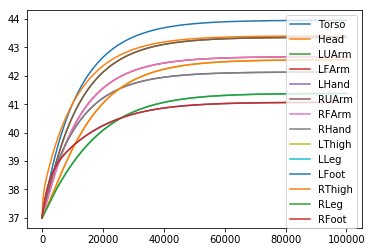

In [8]:
fig_t = plt.figure()
ax_t = fig_t.add_subplot(111)
for i, name in enumerate(names):
    ax_t.plot(temps[:,i], label=name)

ax_t.legend()

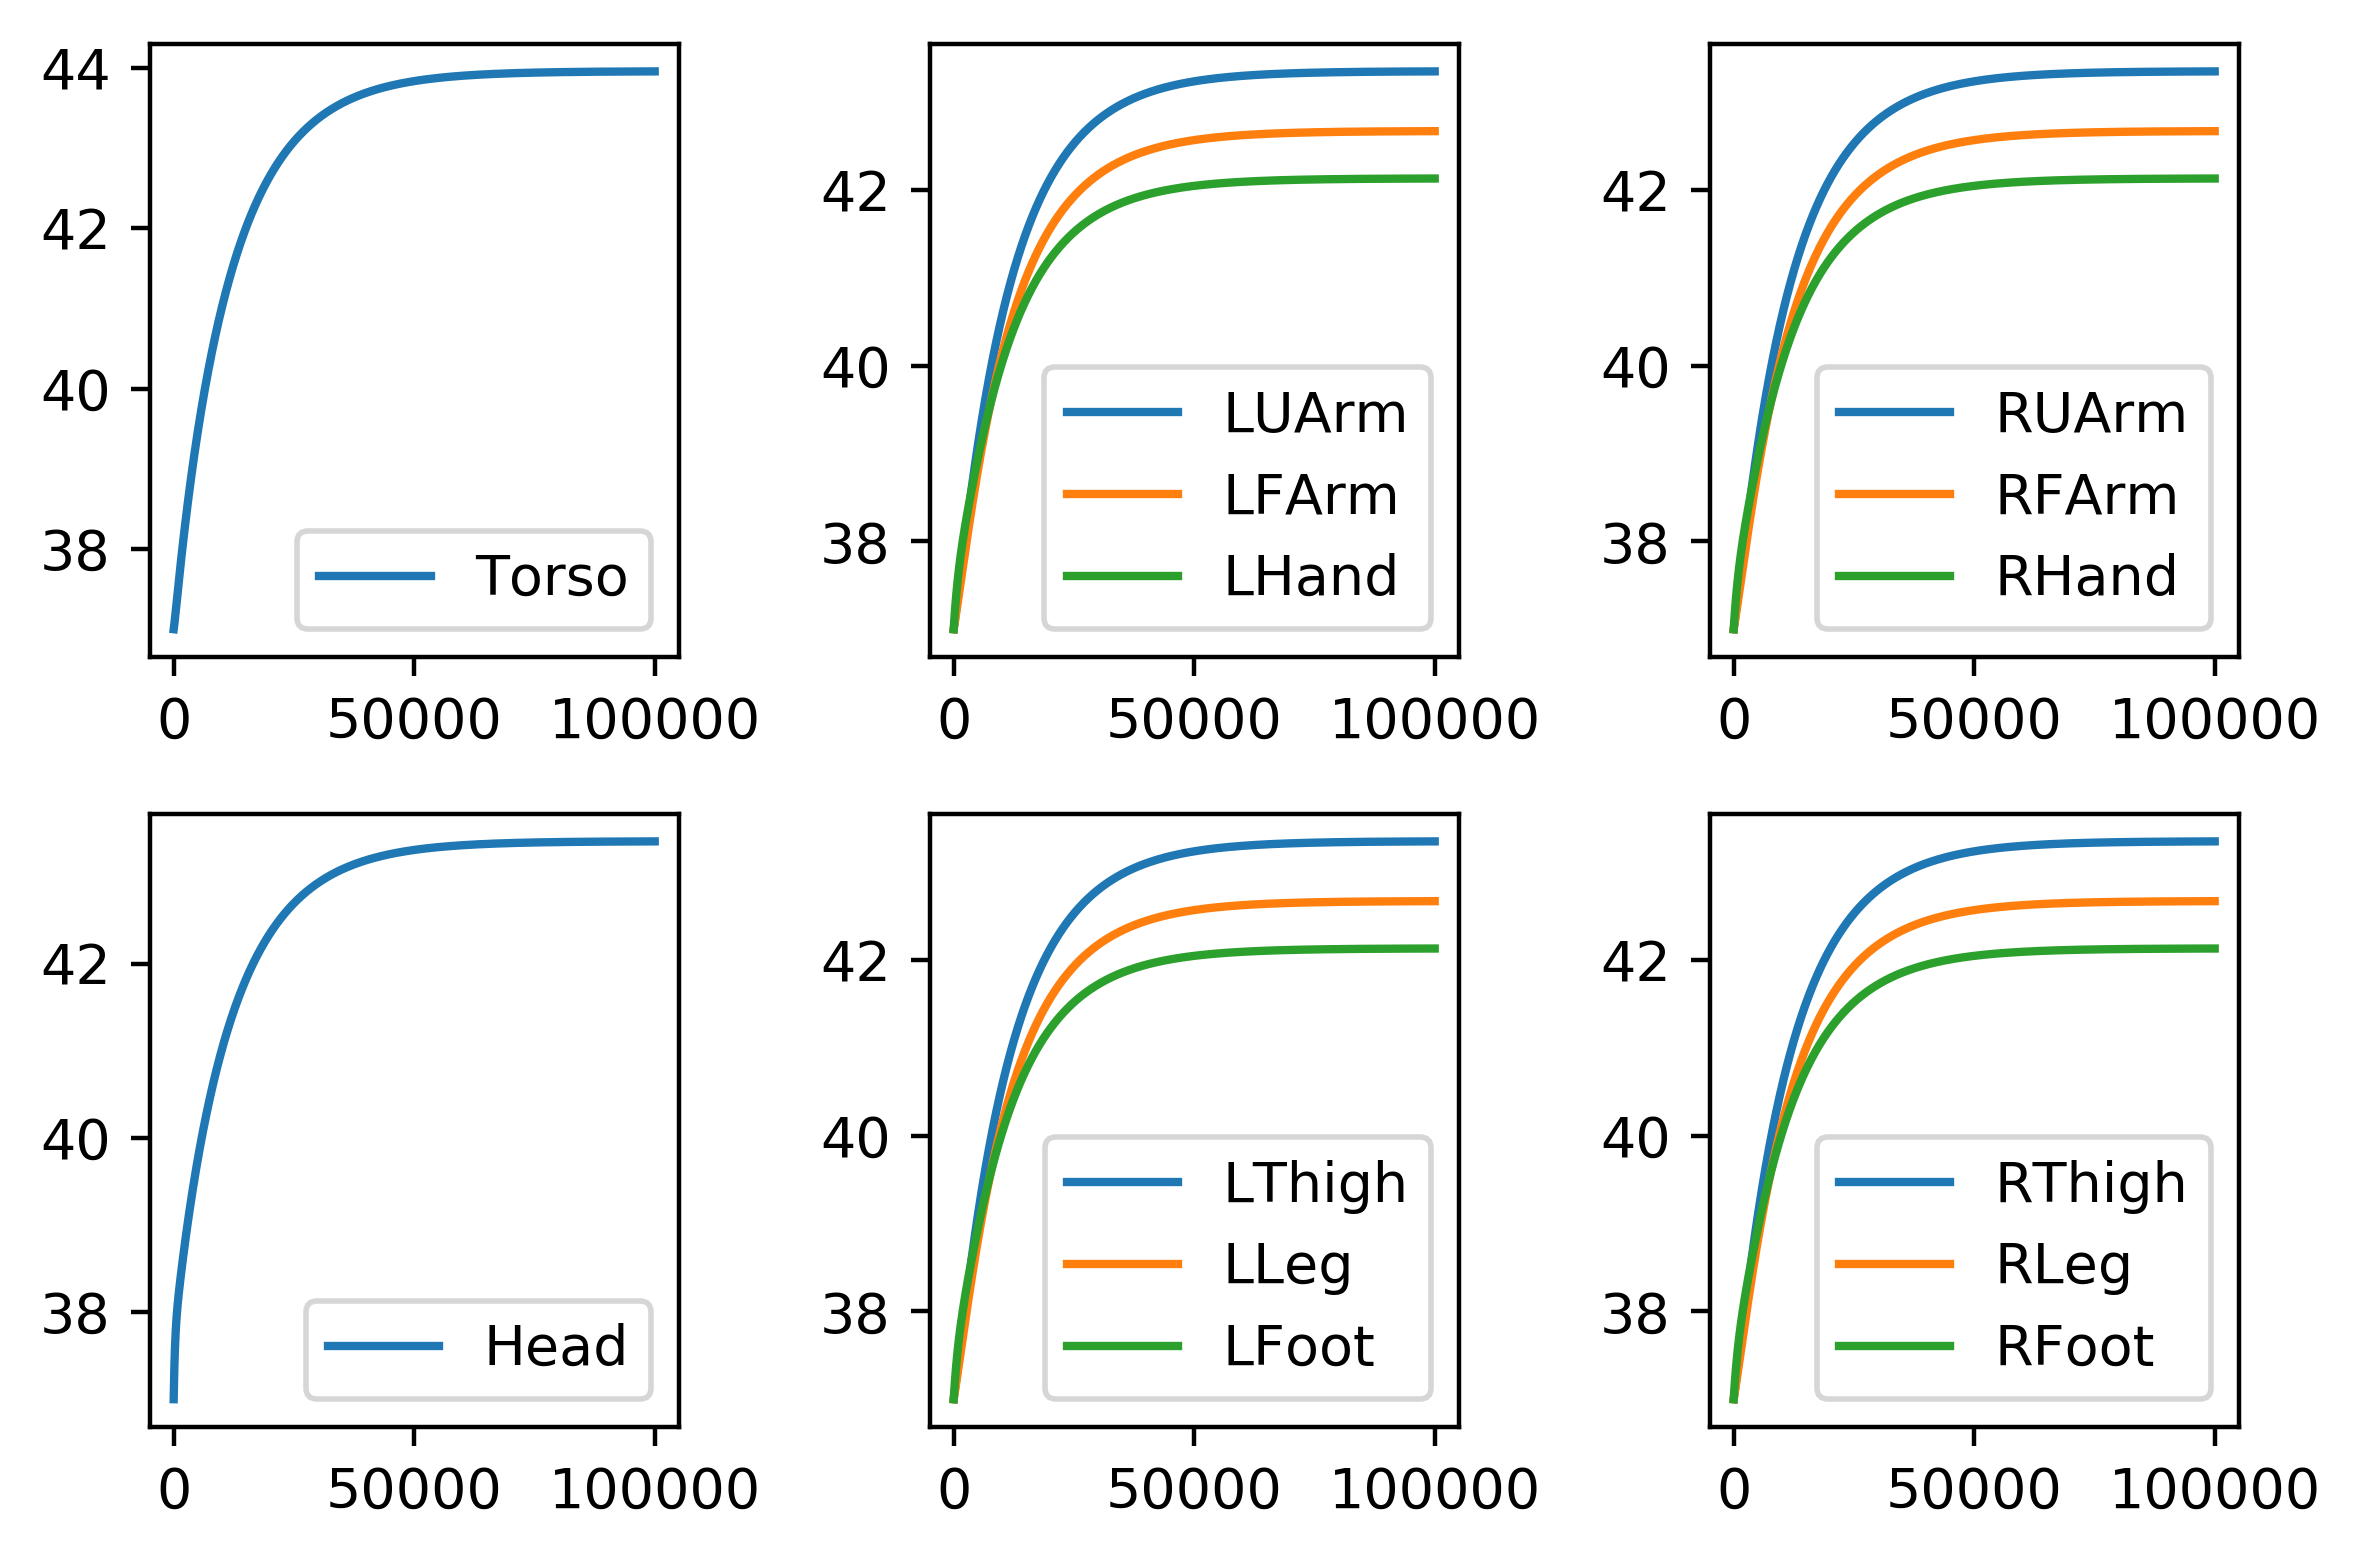

In [9]:
tvals = temps
fig_p = plt.figure(dpi=400)

# Torso plot
ax_t = fig_p.add_subplot(231)
ax_t.plot(tvals[:,0], label=names[0])
ax_t.legend()

# Head plot
ax_h = fig_p.add_subplot(234)
ax_h.plot(tvals[:,1], label=names[1])
ax_h.legend()

# Left Arm
ax_la = fig_p.add_subplot(232)
for i, name in enumerate(names[2:5]):
    ax_la.plot(tvals[:,2+i], label=name)
ax_la.legend()

# Right Arm
ax_ra = fig_p.add_subplot(233)
for i, name in enumerate(names[5:8]):
    ax_ra.plot(tvals[:,2+i], label=name)
ax_ra.legend()

# Left Leg
ax_ll = fig_p.add_subplot(235)
for i, name in enumerate(names[8:11]):
    ax_ll.plot(tvals[:,2+i], label=name)
ax_ll.legend()

# Right Leg
ax_rl = fig_p.add_subplot(236)
for i, name in enumerate(names[11:]):
    ax_rl.plot(tvals[:,2+i], label=name)
ax_rl.legend()

fig_p.tight_layout()

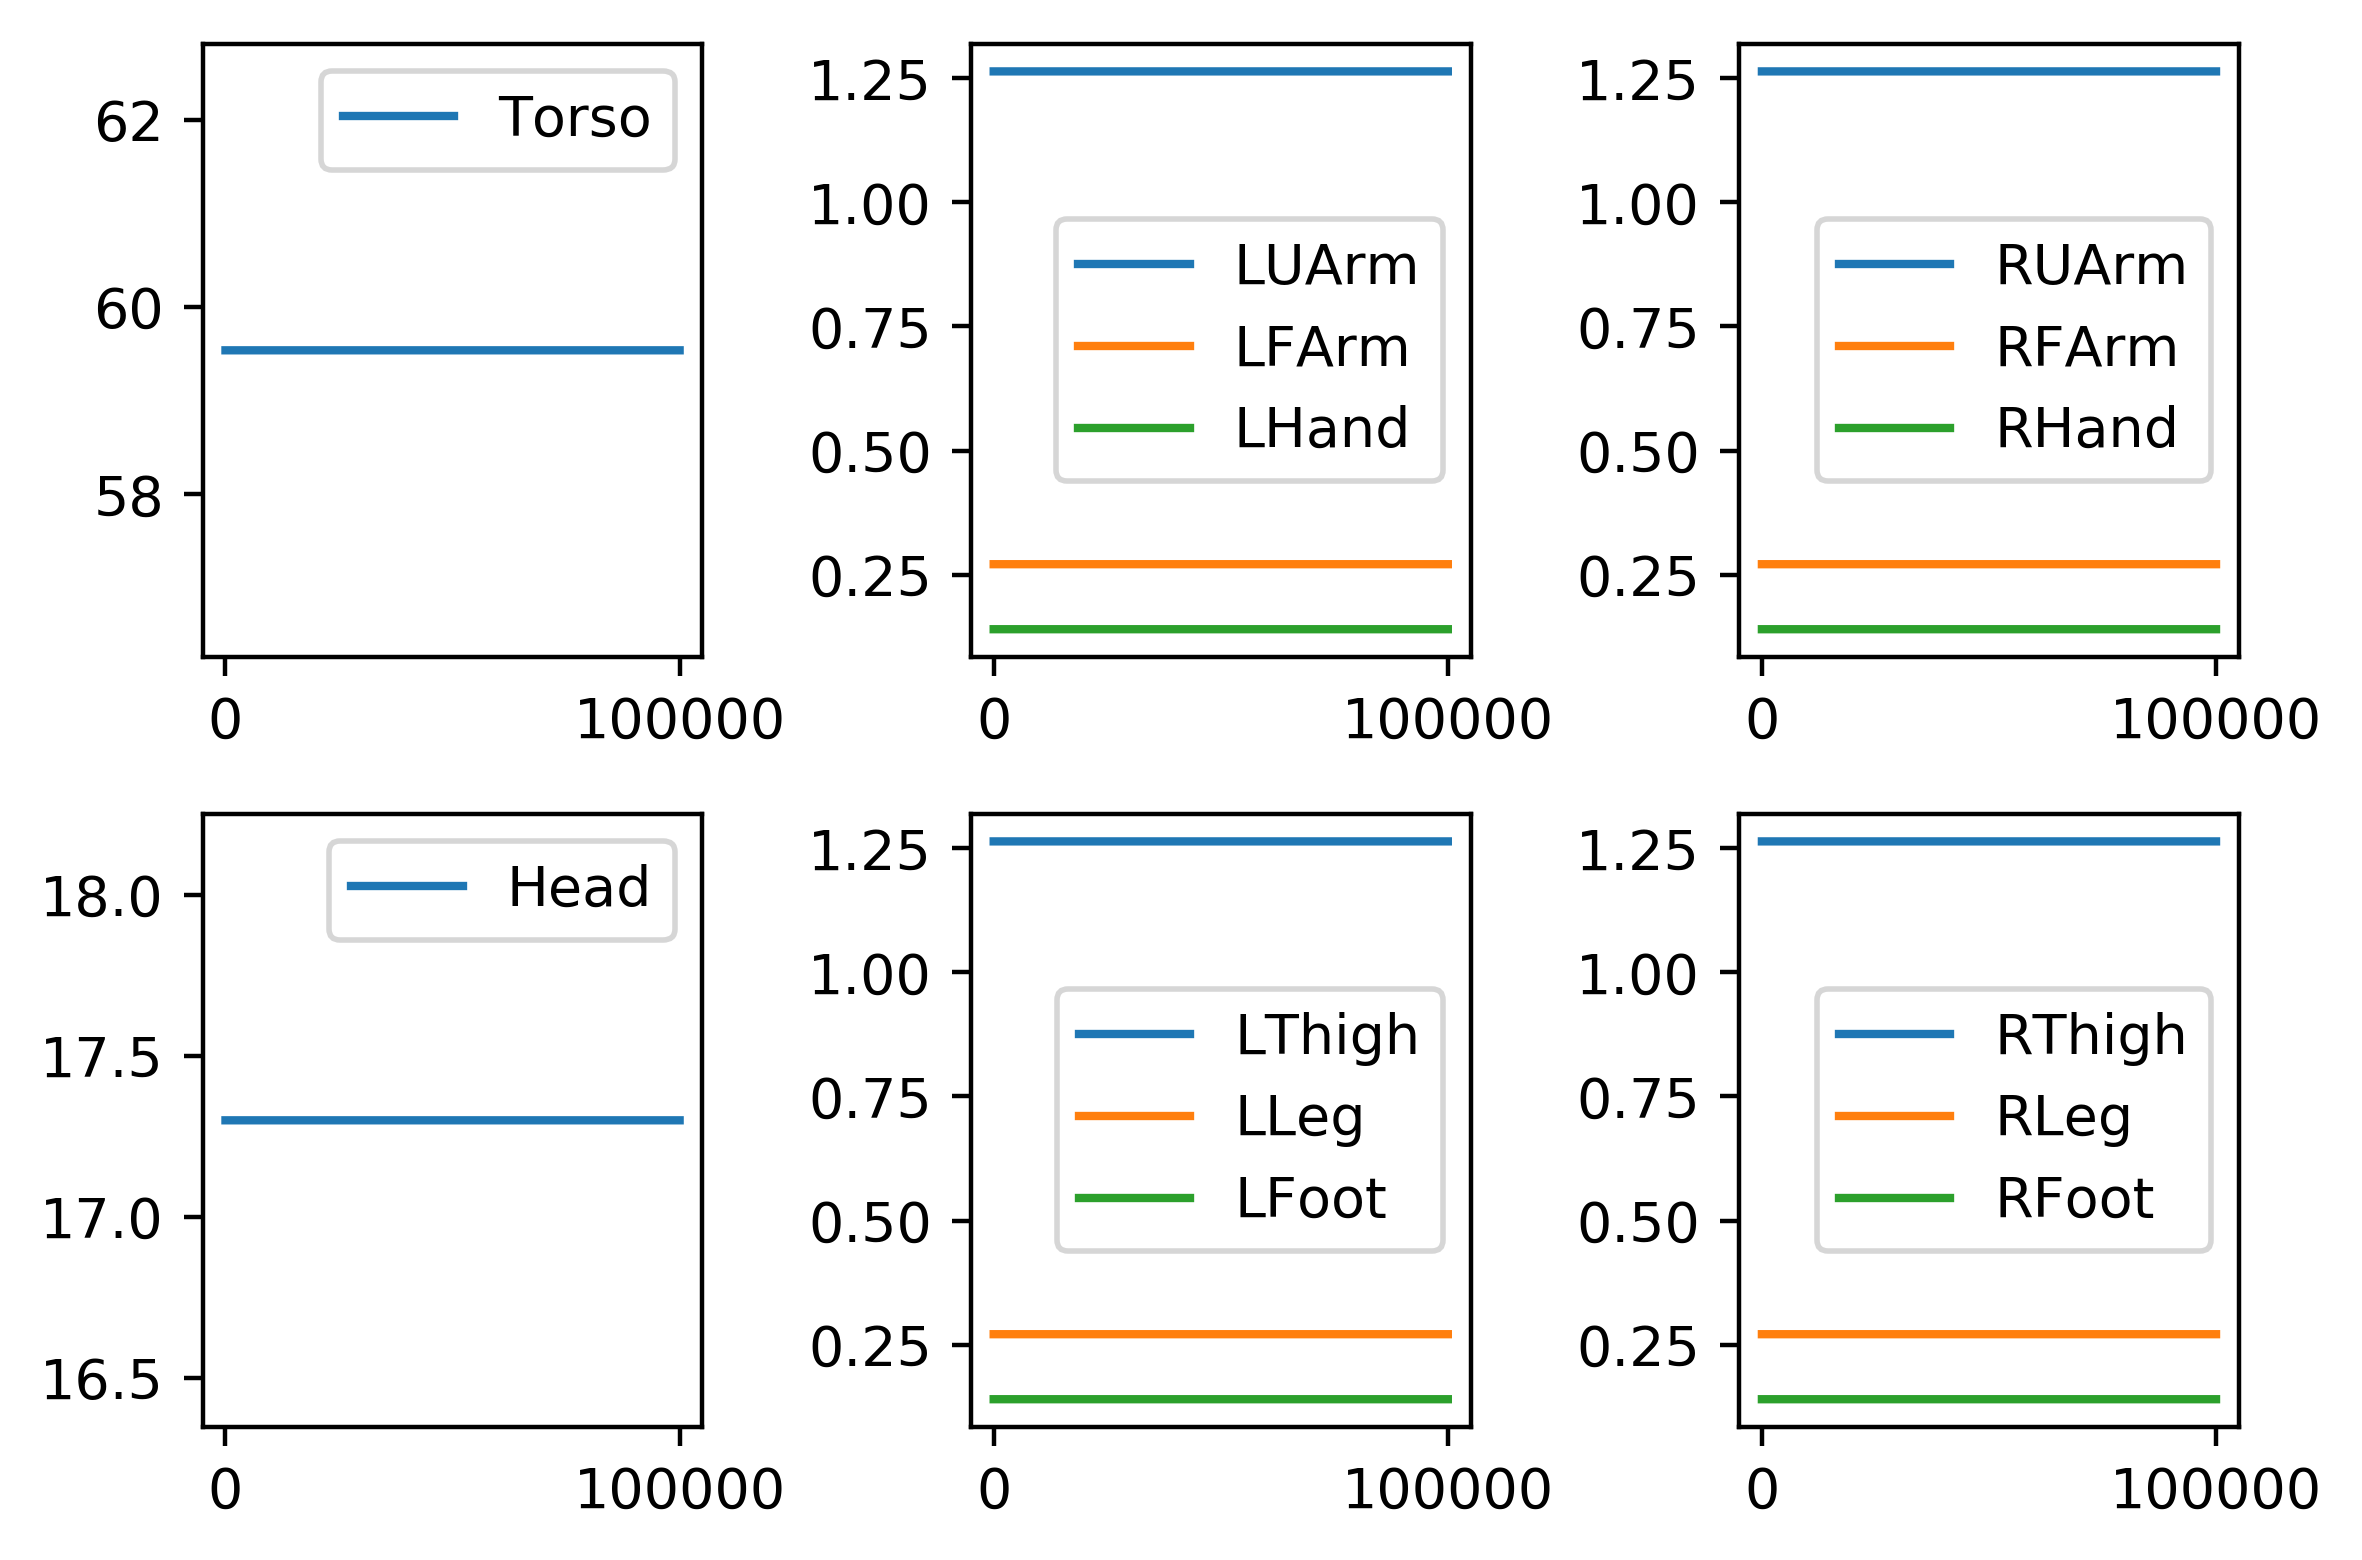

In [10]:
qmets = np.asarray(log["qmet"])

fig_q = plt.figure(dpi=400)

# Torso plot
ax_t = fig_q.add_subplot(231)
ax_t.plot(qmets[:,0], label=names[0])
ax_t.legend()

# Head plot
ax_h = fig_q.add_subplot(234)
ax_h.plot(qmets[:,1], label=names[1])
ax_h.legend()

# Left Arm
ax_la = fig_q.add_subplot(232)
for i, name in enumerate(names[2:5]):
    ax_la.plot(qmets[:,2+i], label=name)
ax_la.legend()

# Right Arm
ax_ra = fig_q.add_subplot(233)
for i, name in enumerate(names[5:8]):
    ax_ra.plot(qmets[:,2+i], label=name)
ax_ra.legend()

# Left Leg
ax_ll = fig_q.add_subplot(235)
for i, name in enumerate(names[8:11]):
    ax_ll.plot(qmets[:,2+i], label=name)
ax_ll.legend()

# Right Leg
ax_rl = fig_q.add_subplot(236)
for i, name in enumerate(names[11:]):
    ax_rl.plot(qmets[:,2+i], label=name)
ax_rl.legend()

fig_q.tight_layout()

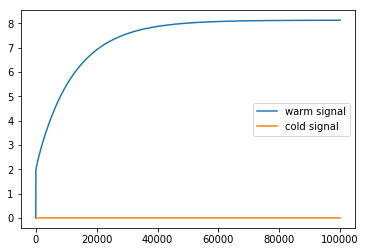

In [11]:
wrms = log["wrm"]
clds = log["cld"]

plt.plot(wrms, label="warm signal")
plt.plot(clds, label="cold signal")
plt.legend()